In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
from pathlib import Path
import transformers as hf

from torchvision.transforms.functional import to_pil_image

c:\Users\snovi\anaconda3\envs\xai-detr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_URL = "facebook/detr-resnet-50"
DEVICE = "cuda"
SAVE_FILEPATH = Path('./resources/results/cats.pkl')  # where the explanation will be saved

- The only things you need is your model and image processor from the Hugging Face's transformers library.

In [4]:
model = hf.DetrForObjectDetection.from_pretrained(MODEL_URL)
processor = hf.DetrImageProcessor.from_pretrained(MODEL_URL)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- **Note**: Make sure that `model.config.id2label` and `model.config.label2id` are correctly set for yout dataset. This information is used for visualization purposes.

In [5]:
list(zip(model.config.id2label.keys(), model.config.label2id.keys()))

[(0, 'N/A'),
 (1, 'airplane'),
 (10, 'apple'),
 (11, 'backpack'),
 (12, 'banana'),
 (13, 'baseball bat'),
 (14, 'baseball glove'),
 (15, 'bear'),
 (16, 'bed'),
 (17, 'bench'),
 (18, 'bicycle'),
 (19, 'bird'),
 (2, 'blender'),
 (20, 'boat'),
 (21, 'book'),
 (22, 'bottle'),
 (23, 'bowl'),
 (24, 'broccoli'),
 (25, 'bus'),
 (26, 'cake'),
 (27, 'car'),
 (28, 'carrot'),
 (29, 'cat'),
 (3, 'cell phone'),
 (30, 'chair'),
 (31, 'clock'),
 (32, 'couch'),
 (33, 'cow'),
 (34, 'cup'),
 (35, 'desk'),
 (36, 'dining table'),
 (37, 'dog'),
 (38, 'donut'),
 (39, 'door'),
 (4, 'elephant'),
 (40, 'eye glasses'),
 (41, 'fire hydrant'),
 (42, 'fork'),
 (43, 'frisbee'),
 (44, 'giraffe'),
 (45, 'hair drier'),
 (46, 'handbag'),
 (47, 'hat'),
 (48, 'horse'),
 (49, 'hot dog'),
 (5, 'keyboard'),
 (50, 'kite'),
 (51, 'knife'),
 (52, 'laptop'),
 (53, 'microwave'),
 (54, 'mirror'),
 (55, 'motorcycle'),
 (56, 'mouse'),
 (57, 'orange'),
 (58, 'oven'),
 (59, 'parking meter'),
 (6, 'person'),
 (60, 'pizza'),
 (61, 'plat

In [6]:
import xai_transformers.detr as xai_detr

In [7]:
explainer = xai_detr.DetrExplainer(model=model, processor=processor)

In [8]:
image = Image.open(Path(r'resources\demo\cats.jpg'))

In [9]:
output = explainer.explain_image(
    image=image, 
    score_threshold=0.7,                # explain only detections with confidence score >= 0.7
    area_threshold=0.3,                 # explain only detections covering at least 30% of the image
    include_labels=['cat', 'remote'],   # explain only detections with prediction class 'cat' or 'remote'
    device=DEVICE                       # use GPU if available
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


- The output of the `DetrExplainer` class is based on `DetrOutputForObjectDetection` (see [documentation](https://huggingface.co/docs/transformers/en/model_doc/detr#transformers.models.detr.modeling_detr.DetrObjectDetectionOutput)). 
- For our purpose we only keep the following fields from the original output: **logits**, **pred_boxes** ,**encoder_attentions**, **decoder_attentions** and **cross_attentions**.

- **Note**: Since the explainer processes one image at a time, the batch dimension is removed from each of these fields.

- Additionally, the `DetrExplainer` output includes the following fields:

  - **`query_ids`**: The indices of the query tokens associated with each explained detection. It has shape of (`N`) where `N` is the number of explained detections.

  - **`relevance_maps`**: Relevance maps for each explained detection. It has shape of (`N`, `H`, `W`) where `H` and `W` are the height and width of the low-resolution convolutional feature map output by the backbone.

  - **`metrics`**: Evaluation metrics for each explained detection, computed using the `TokenPerturbationEvaluator` class.
    - It's a dictionary with the following format:
    
      ```python
      {
          query_id: {
              mode: {                         # mode can be 'insertion' and 'deletion', both can be used for the same query
                score: float,                 # overall score of the evaluation
                scores: List[float],          # scores for each step of the evaluation
                iou_scores: List[float],      # iou scores for each step of the evaluation
                cosine_scores: List[float],   # cosine scores for each step of the evaluation
                percent_per_step: float       # percentage of the perturbation per step used for the evaluation
              }
          }
      }


In [10]:
print(str(output))

XaiDetrObjectDetectionOutput(
  query_ids: [61, 98]
  relevance_maps: Tensor with shape (2, 25, 34)
  logits: Tensor with shape (2, 92)
  pred_boxes: Tensor with shape (2, 4)
  encoder_attentions: 6 tensors with shapes (8, 850, 850)
  decoder_attentions: 6 tensors with shapes (8, 100, 100)
  cross_attentions: 6 tensors with shapes (8, 100, 850)
)


- You can iterate through each detection in the output:

In [11]:
item_iter = iter(output)

In [12]:
print(str(next(item_iter)))

XaiDetectionItem(
  query_id: 61
  logits: Tensor with shape (92,)
  pred_box: Tensor with shape (4,)
  relevance_map: Tensor with shape (25, 34)
)


- Move the **output** to `cpu` to avoid memory overflow and to be used by the `DetrVisualizer`

In [13]:
output = output.to('cpu')

- Instantiate `DetrVisualizer` to visualize the output of the explainer.

In [14]:
visualizer = xai_detr.DetrVisualizer(processor=processor, id2label=model.config.id2label)

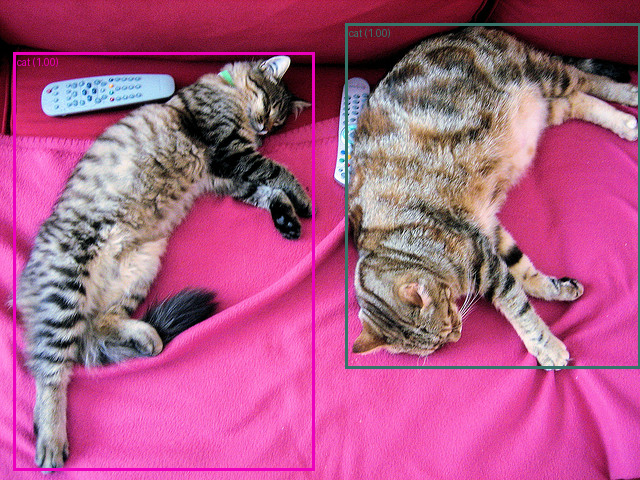

In [15]:
visualizer.draw_detections(image=image, output=output, to_pil=True, together=True)

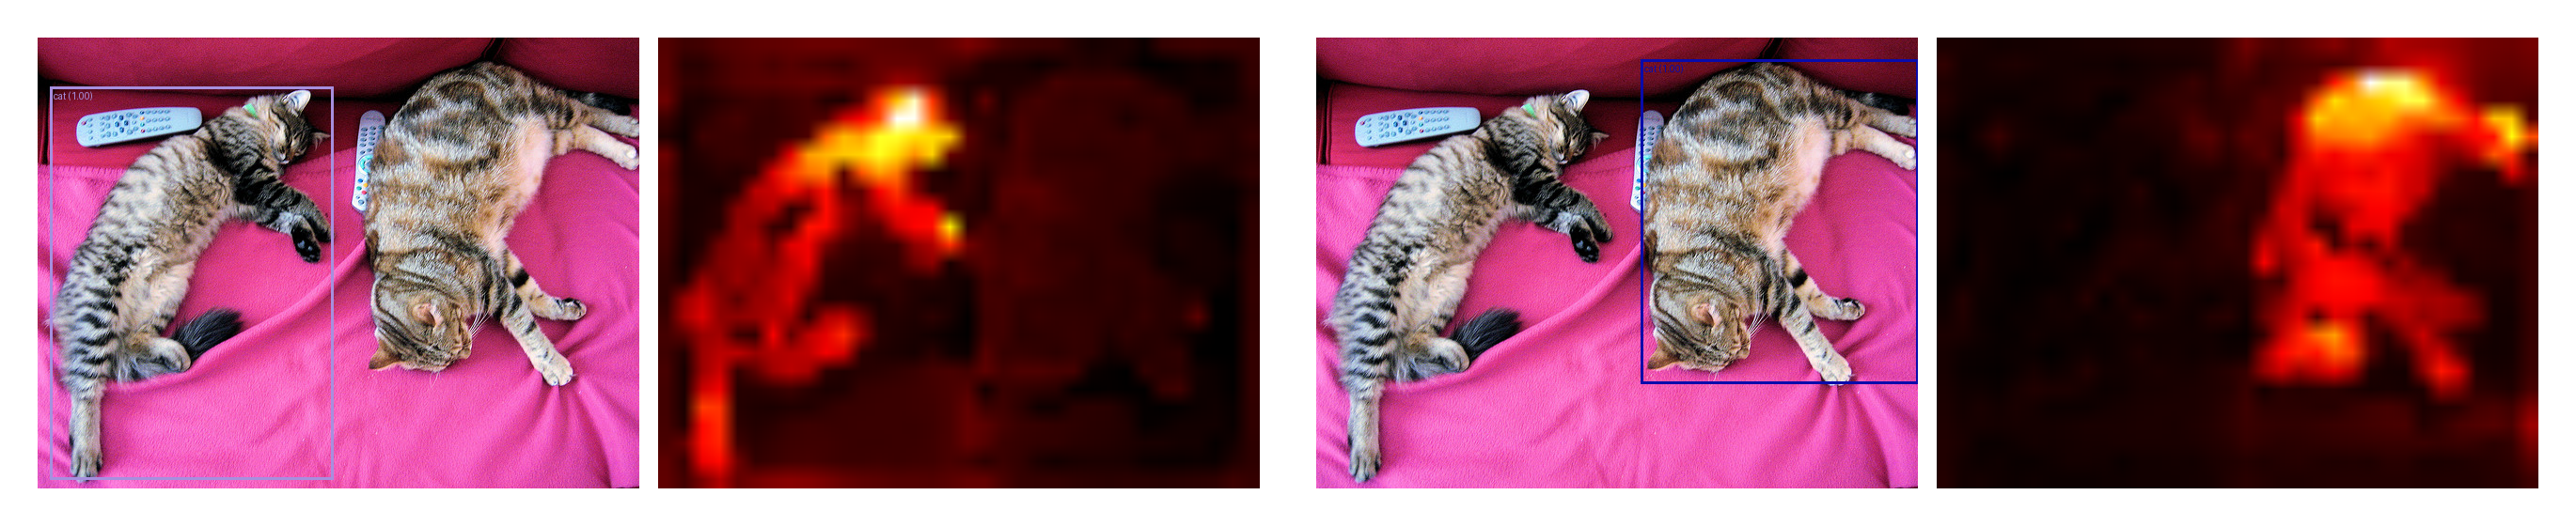

In [16]:
visualizer.draw_detections_and_relevance_maps(image=image, output=output, to_pil=True, grid=True)

- Use the `TokenPerturbationEvaluator` to evaluate the relevance maps generated by the explainer.

In [17]:
evaluator = xai_detr.TokenPerturbationEvaluator(model=model, processor=processor)

In [18]:
viz_results = evaluator.evaluate(
    image=image,
    xai_output=output,
    mode='deletion',                # `deletion` or `insertion`
    percent_per_step=0.02,          # percentage of perturbation per step (0.02 = 2%)
    batch_size=2,               
    device=DEVICE,
    show_progress=True,             # if enabled, it will generate a frame for each step which visualizes the perturbation
    visualizer=visualizer           # if show_progress is enabled, the visualizer must be provided too
)

In [19]:
print(str(next(iter(output))))  # the `metrics` was created in the output with the `mode` used in `evaluator.evaluate`

XaiDetectionItem(
  query_id: 61
  logits: Tensor with shape (92,)
  pred_box: Tensor with shape (4,)
  relevance_map: Tensor with shape (25, 34)
  metrics: ['deletion']
)


- If **show_progress** is True and **visualizer**  is provided, the evaluator will return a dictionary with the generated frames for each query, otherwise it will return None.

In [20]:
viz_results.keys()

dict_keys([61, 98])

In [21]:
QUERY_ID, STEP = 61, 2

In [22]:
viz_results[QUERY_ID].shape   # 50 frames were generated for detection with query_id == 61

torch.Size([50, 3, 480, 640])

- In the third step, 3 x 2% = 6% of image tokens were masked (the ones colored in gray)
- The detection in blue is the original detection
- The detection in green is the most similar detection to the original one at the third step
- These masks are applied to image tokens, not the original image. They're overlaid on the image for reference, showing where each token corresponds. However, each token's effective receptive field is much larger due to the model's backbone stacked convolutions.

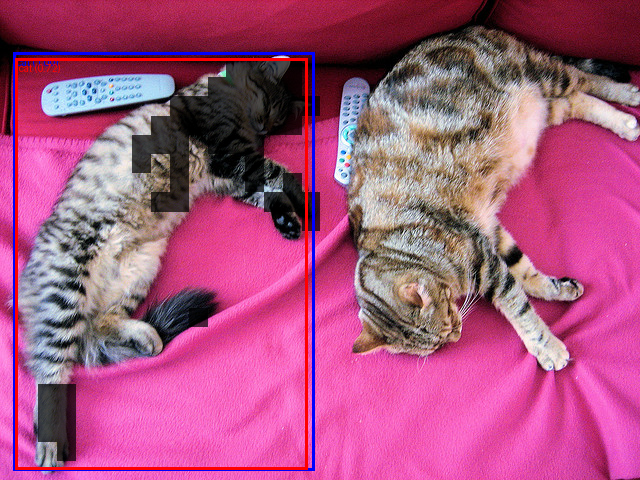

In [23]:
to_pil_image(viz_results[QUERY_ID][STEP])

- Save the output

In [24]:
output.save(filepath=SAVE_FILEPATH, keep_attentions=False)

- Load the output 

In [25]:
saved_output = xai_detr.XaiDetrObjectDetectionOutput.load(filepath=SAVE_FILEPATH)

In [26]:
print(str(saved_output))  # the `attention` fields were not saved to reduce memory usage

XaiDetrObjectDetectionOutput(
  query_ids: [61, 98]
  relevance_maps: Tensor with shape (2, 25, 34)
  logits: Tensor with shape (2, 92)
  pred_boxes: Tensor with shape (2, 4)
)
